# **End-to-end Churn Prediction Project**
#### **Table of Contents**
1. Project Overview
2. Data Collection & Initial Steps
3. Sample
4. Explore
5. Modify
6. Model
7. Assess
8. Results & Insights

## **1. Project Overview**

#### **Problem Statement**

In the modern banking landscape, customer retention plays a critical role in maintaining long-term profitability. Acquiring new customers is significantly more expensive than retaining existing ones. This project aims to build a predictive model to flag potential churners for a bank’s credit card services, enabling the bank to take targeted retention actions.

#### **Objective**

The main goal of this study is to:

- **Predict** which customers are likely to churn (i.e., stop using the credit card service).
- **Identify** the key factors influencing churn decisions.
- **Provide** actionable business recommendations based on predictive insights.

#### **Data Understanding**

The dataset used in this project comes from Kaggle:
[Credit Card Customers Dataset](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers)

It contains 10,127 observations and 21 variables, describing customers’ demographic information, relationship with the bank, and activity patterns.

Each record corresponds to one customer, and the target variable is Attrition_Flag, which indicates whether the customer has churned.

#### **Data Fields Overview**

| Feature                    | Description                                                             |
| -------------------------- | ----------------------------------------------------------------------- |
| `CLIENTNUM`                | Unique customer identifier                                              |
| `Attrition_Flag`           | Customer status: *Existing Customer* or *Attrited Customer*             |
| `Customer_Age`             | Age of the customer                                                     |
| `Gender`                   | Gender of the customer (M/F)                                            |
| `Dependent_count`          | Number of dependents of the customer                                    |
| `Education_Level`          | Highest level of education attained                                     |
| `Marital_Status`           | Marital status (Married, Single, Divorced, etc.)                        |
| `Income_Category`          | Annual income range                                                     |
| `Card_Category`            | Type of credit card (Blue, Silver, Gold, Platinum)                      |
| `Months_on_book`           | Period of relationship with the bank (in months)                        |
| `Total_Relationship_Count` | Total number of products held by the customer                           |
| `Months_Inactive_12_mon`   | Number of inactive months in the last 12 months                         |
| `Contacts_Count_12_mon`    | Number of contacts with the bank in the last 12 months                  |
| `Credit_Limit`             | Credit limit on the credit card                                         |
| `Total_Revolving_Bal`      | Total revolving balance on the credit card                              |
| `Avg_Open_To_Buy`          | Average open-to-buy credit line                                         |
| `Total_Amt_Chng_Q4_Q1`     | Ratio of total transaction amount (Q4/Q1)                               |
| `Total_Trans_Amt`          | Total transaction amount in the last 12 months                          |
| `Total_Trans_Ct`           | Total transaction count in the last 12 months                           |
| `Total_Ct_Chng_Q4_Q1`      | Ratio of total transaction count (Q4/Q1)                                |
| `Avg_Utilization_Ratio`    | Average card utilization ratio                                          |

#### **Methodology: SEMMA**
We will follow the **SEMMA** methodology from the SAS Institute, which provides a structured framework for data mining:
- **Sample:** Create a representative sample of the data.
- **Explore:** Visualize and analyze data to discover patterns and anomalies.
- **Modify:** Prepare data for modeling (cleaning, transformation, feature engineering).
- **Model:** Train and compare multiple machine learning algorithms.
- **Assess:** Evaluate model performance on a hold-out test set.


## **2. Data Collection & Initial Setup**
**Import Libraries**

In [ ]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_rel
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

**Import Data from MySQL as DataFrame**

In [2]:

with pymysql.connect(
    host="localhost",
    user="pedro",
    password="12345",
    database="bank_db",
    charset='utf8mb4',
    cursorclass=pymysql.cursors.DictCursor
) as conn:
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM churners;')
    data = cursor.fetchall()
    

In [3]:
df = pd.DataFrame(data)

**Show Top 5 Records**

In [4]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691,777,11914,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256,864,7392,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418,0,3418,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313,2517,796,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716,0,4716,2.175,816,28,2.500,0.000


**Shape of the dataset**

In [5]:
df.shape

(10127, 21)

**Summary of the dataset**

In [6]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.938679,1162.814061,7469.124617,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.788539,814.987335,9090.695763,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.000000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


**Check null and datatypes in the dataset**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  int64  
 14  Total_

**Target distribution in the dataset**

In [8]:
df['Attrition_Flag'].value_counts()

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

**Replacing target values and column name**

In [9]:
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Attrited Customer': 1,
                                                 'Existing Customer': 0})
df['Churn'] = df['Attrition_Flag']
df.drop(columns='Attrition_Flag', inplace=True) 

## **3. Sample**

In [ ]:
features = df.columns[1:-1] # Without 'CLIENTNUM' column
target = 'Churn'
X, y = df[features], df[target] 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

In [11]:
print("Target proportion train:", y_train.mean())
print("Target proportion test:", y_test.mean())

Target proportion train: 0.1607208986544871
Target proportion test: 0.16041461006910168


## **4. Explore**

In [12]:
churn_counts = y_train.value_counts()
print('Churn distribution in the train set \n', churn_counts,'\n')

churn_rates = y_train.value_counts()/len(y_train)*100
print('Churn rate in the train set \n', churn_rates)


Churn distribution in the train set 
 Churn
0    6799
1    1302
Name: count, dtype: int64 

Churn rate in the train set 
 Churn
0    83.92791
1    16.07209
Name: count, dtype: float64


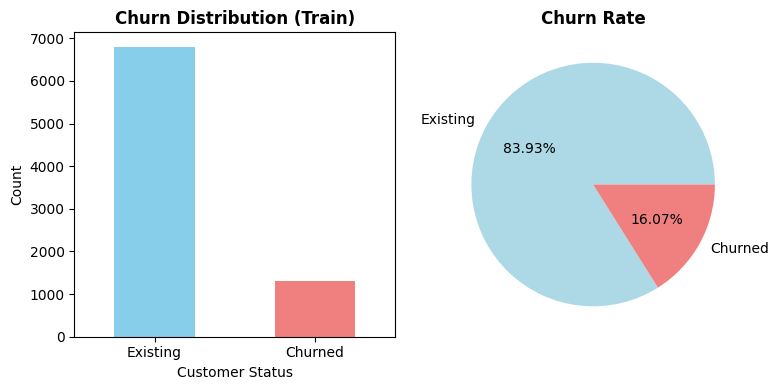

In [13]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
churn_counts.plot(kind='bar', color=['skyblue','lightcoral'])
plt.title('Churn Distribution (Train)', fontweight='bold')
plt.xlabel('Customer Status')
plt.ylabel('Count') 
plt.xticks(ticks=[0, 1], labels=['Existing', 'Churned'], rotation=0)

plt.subplot(1,2,2)
plt.pie(churn_counts, 
        labels=['Existing','Churned'], 
        autopct="%1.2f%%", 
        colors=['lightblue', 'lightcoral'])
plt.title('Churn Rate', fontweight='bold')

plt.tight_layout()
plt.show()


**Define DataFrame with train data to explore**

In [14]:
df_explore = X_train.copy()
df_explore[target] = y_train
df_explore.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
2856,36,F,0,Unknown,Married,Less than $40K,Blue,24,4,3,2,2570,2230,340,0.686,1755,42,0.448,0.868,0
6515,44,M,3,High School,Single,$60K - $80K,Silver,36,5,2,3,25276,0,25276,0.849,2282,38,0.583,0.000,1
7141,46,M,2,High School,Married,$80K - $120K,Blue,30,6,3,1,11670,915,10755,0.892,4277,89,0.854,0.078,0
632,36,F,2,Graduate,Married,Less than $40K,Blue,24,3,1,3,3124,1593,1531,0.869,1652,41,0.367,0.510,0
3496,50,M,1,Graduate,Single,$120K +,Blue,40,4,2,3,34516,1185,33331,0.725,3874,72,0.714,0.034,0


### **4.1 Explore Categorical Columns**

**Bar plots**

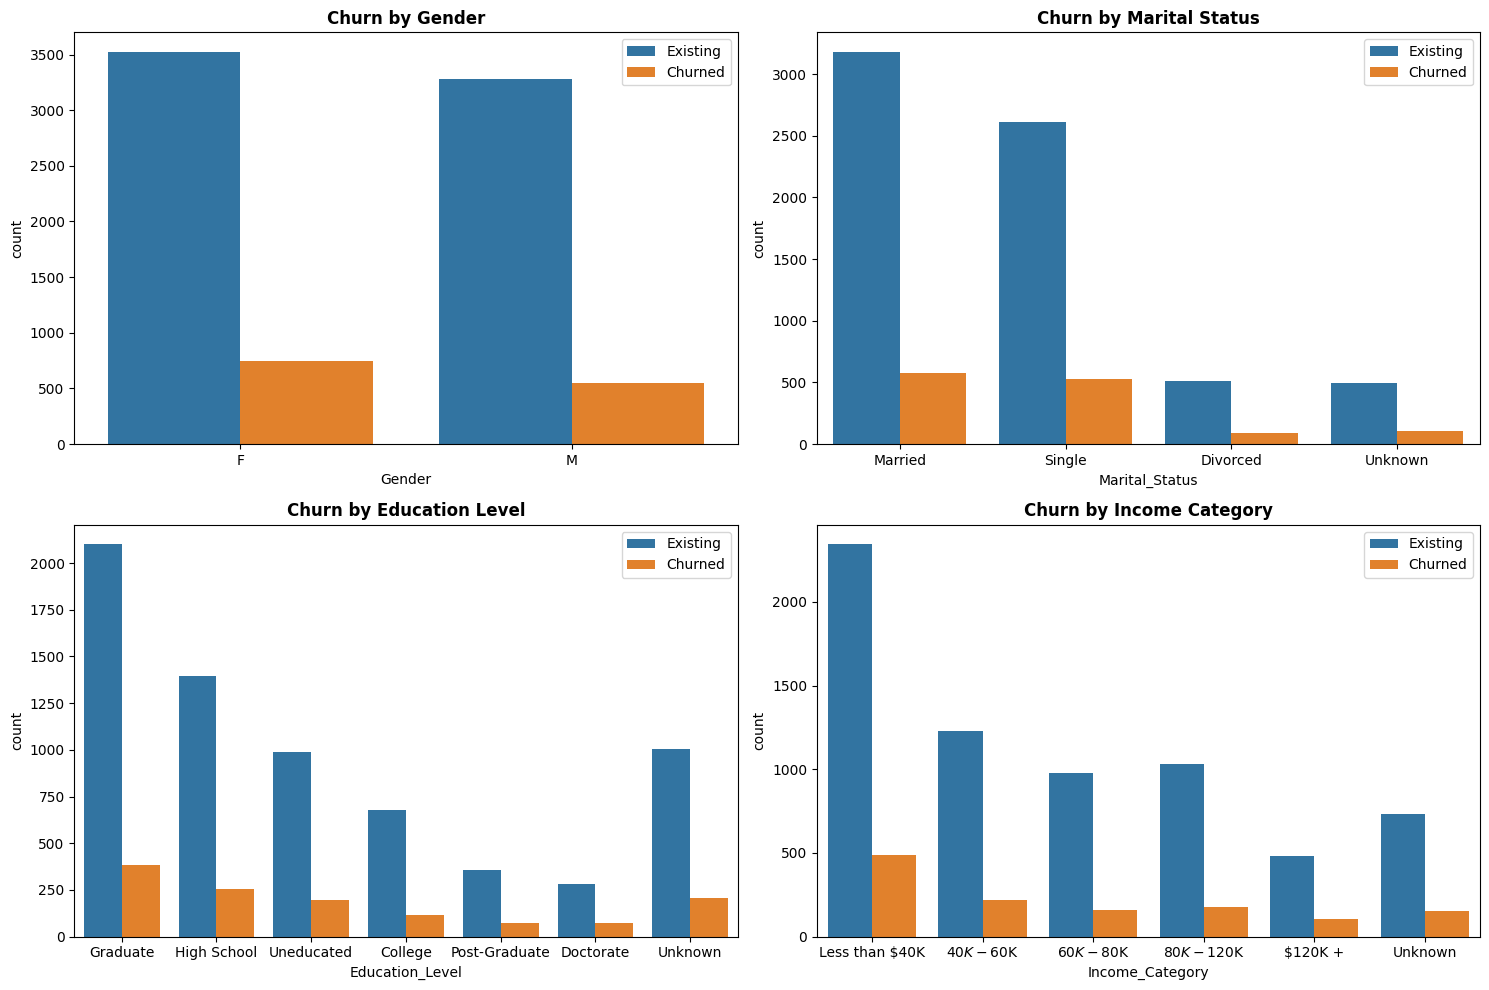

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gender
sns.countplot(data=df_explore, x='Gender', hue='Churn', ax=axes[0,0])
axes[0,0].set_title('Churn by Gender', fontweight='bold')
axes[0,0].legend(['Existing', 'Churned'])

# Marital status
sns.countplot(data=df_explore, x='Marital_Status', hue='Churn', ax=axes[0,1])
axes[0,1].set_title('Churn by Marital Status', fontweight='bold')
axes[0,1].legend(['Existing', 'Churned'])

# Education level
education_order = ['Graduate', 'High School', 'Uneducated', 'College', 'Post-Graduate', 'Doctorate', 'Unknown']
sns.countplot(data=df_explore, x='Education_Level', hue='Churn', ax=axes[1,0], order=education_order)
axes[1,0].set_title('Churn by Education Level', fontweight='bold')
axes[1,0].legend(['Existing', 'Churned'])

# Income category
income_order = ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +', 'Unknown']
sns.countplot(data=df_explore, x='Income_Category', hue='Churn', ax=axes[1,1], order=income_order)
axes[1,1].set_title('Churn by Income Category', fontweight='bold')
axes[1,1].legend(['Existing', 'Churned'])

plt.tight_layout()
plt.show()

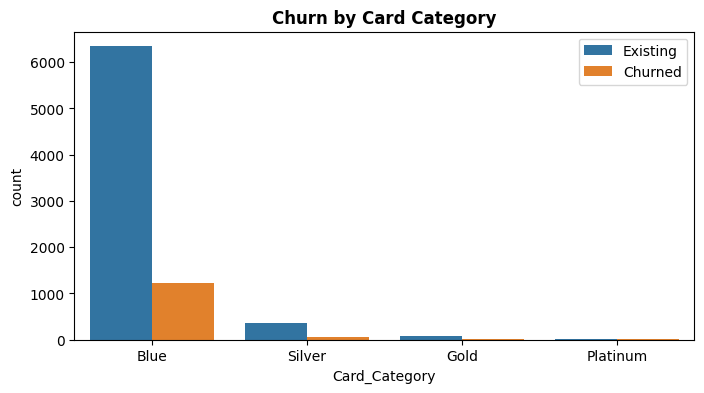

In [16]:
plt.figure(figsize=(8,4))

# Card category
sns.countplot(data=df_explore, x='Card_Category', hue='Churn')
plt.title('Churn by Card Category', fontweight='bold')
plt.legend(['Existing', 'Churned'])

plt.show()

**Compare churn rates between categories and groups**

In [17]:
categorical_cols = df_explore.select_dtypes(include='object').columns.to_list()

for col in categorical_cols:
    summary_cat = df_explore.groupby(by=col)[target].mean().sort_values(ascending=False)
    print(summary_cat,'\n')

Gender
F    0.175328
M    0.144424
Name: Churn, dtype: float64 

Education_Level
Doctorate        0.205056
Unknown          0.169843
Post-Graduate    0.168618
Uneducated       0.165680
High School      0.155152
Graduate         0.153908
College          0.148241
Name: Churn, dtype: float64 

Marital_Status
Unknown     0.178512
Single      0.169001
Married     0.153395
Divorced    0.145242
Name: Churn, dtype: float64 

Income_Category
$120K +           0.178571
Unknown           0.172686
Less than $40K    0.172316
$40K - $60K       0.151724
$80K - $120K      0.148056
$60K - $80K       0.138204
Name: Churn, dtype: float64 

Card_Category
Platinum    0.235294
Gold        0.191489
Blue        0.161132
Silver      0.143852
Name: Churn, dtype: float64 



**Insights**

- Both male and female customers show similar churn rates, but female customers exhibit a slightly higher rate.
- Most customers are graduates or high school educated. Customers with a Doctorate degree show the highest churn rate.
- Churn is highest among both the lowest and highest income brackets, forming a U-shaped relationship.
- The vast majority of customers own a Blue card, which also shows the highest churn count due to its large population.
- Churn rates are similar across the majority of groups, so we need more analysis to drive conclusion. 


### **4.2 Explore Numeric Columns**

In [18]:
numeric_cols = df_explore.select_dtypes(include=np.number).columns.to_list()
numeric_cols


['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Churn']

**Histograms**

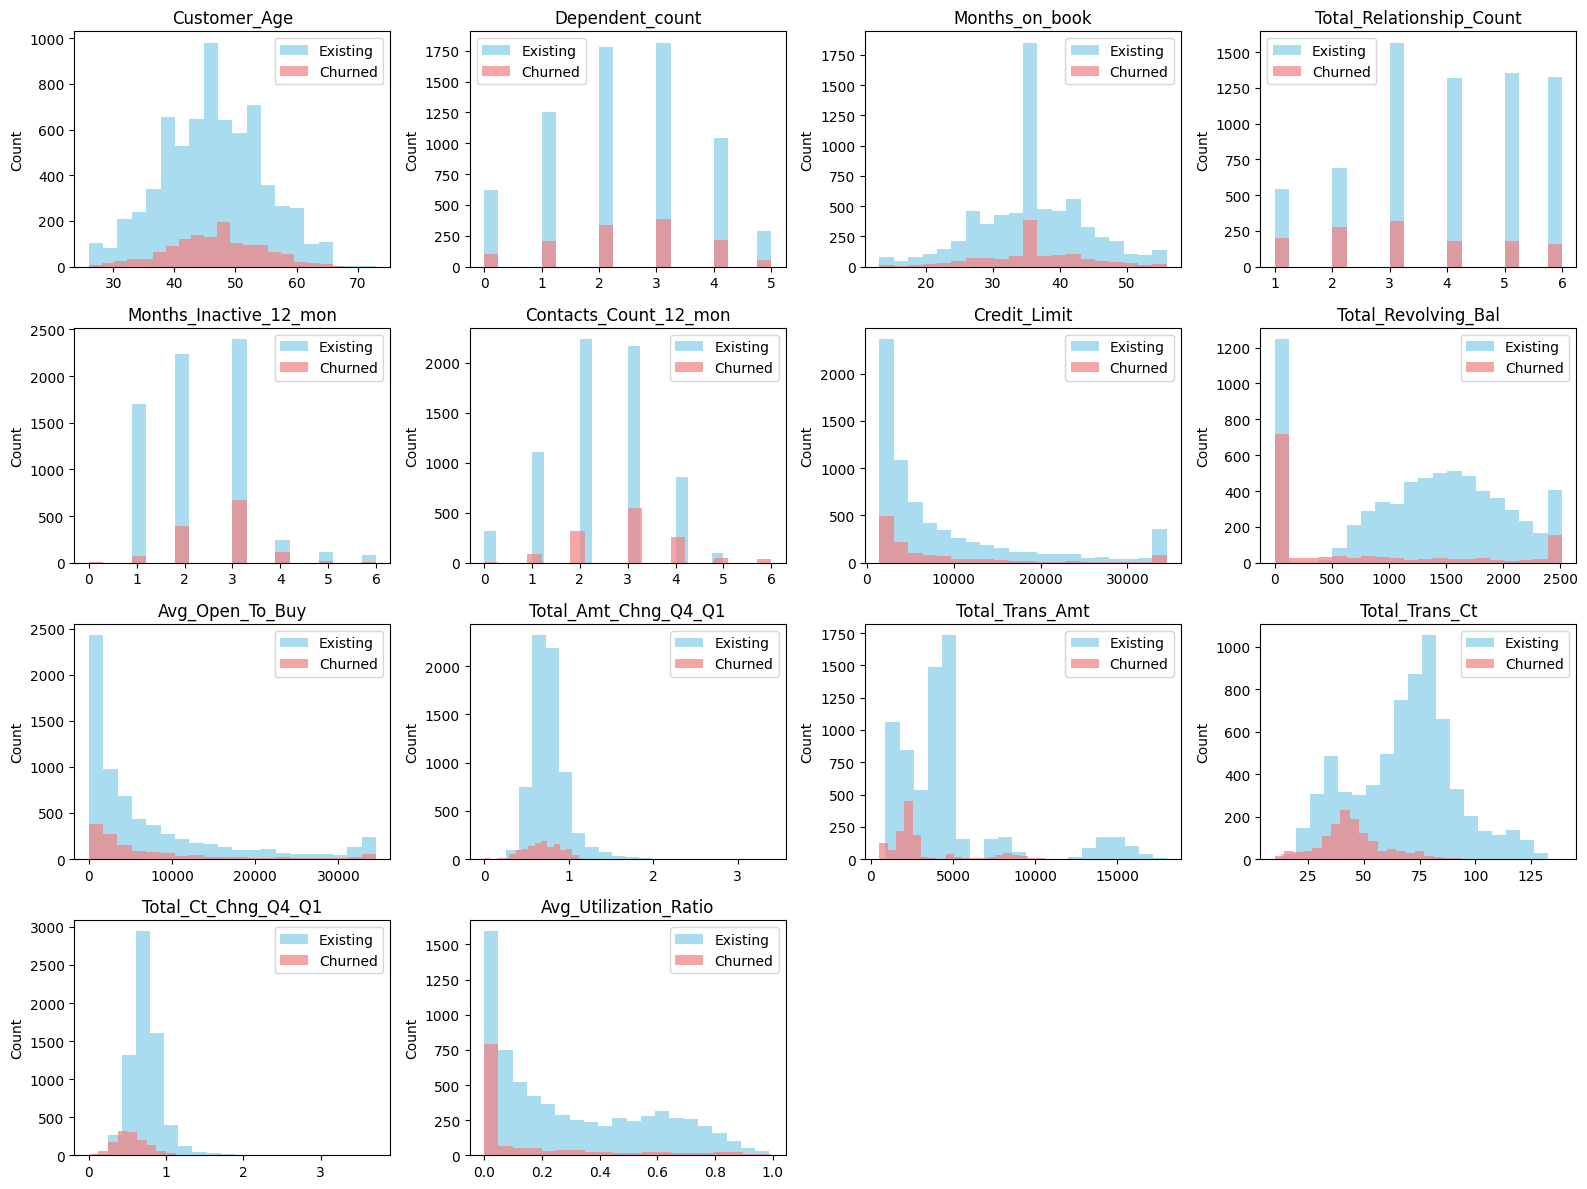

In [19]:
existing = df_explore[df_explore['Churn'] == 0]
churned = df_explore[df_explore['Churn'] == 1]

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols[:-1]):
    axes[i].hist(existing[col], alpha=0.7, label='Existing', bins=20, color='skyblue')
    axes[i].hist(churned[col], alpha=0.7, label='Churned', bins=20, color='lightcoral')
    axes[i].set_title(col)
    axes[i].set_ylabel('Count')
    axes[i].legend()

# Hide empty subplots
for i in range(len(numeric_cols[:-1]), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

**Insights**

- Transactional activity (e.g., total transaction count and amount) tends to be lower among churned customers, suggesting disengagement before leaving.

- Credit-related variables (e.g., credit limit, revolving balance, utilization ratio) show strong right-skewed distributions, typical for financial data.


**Boxplots**

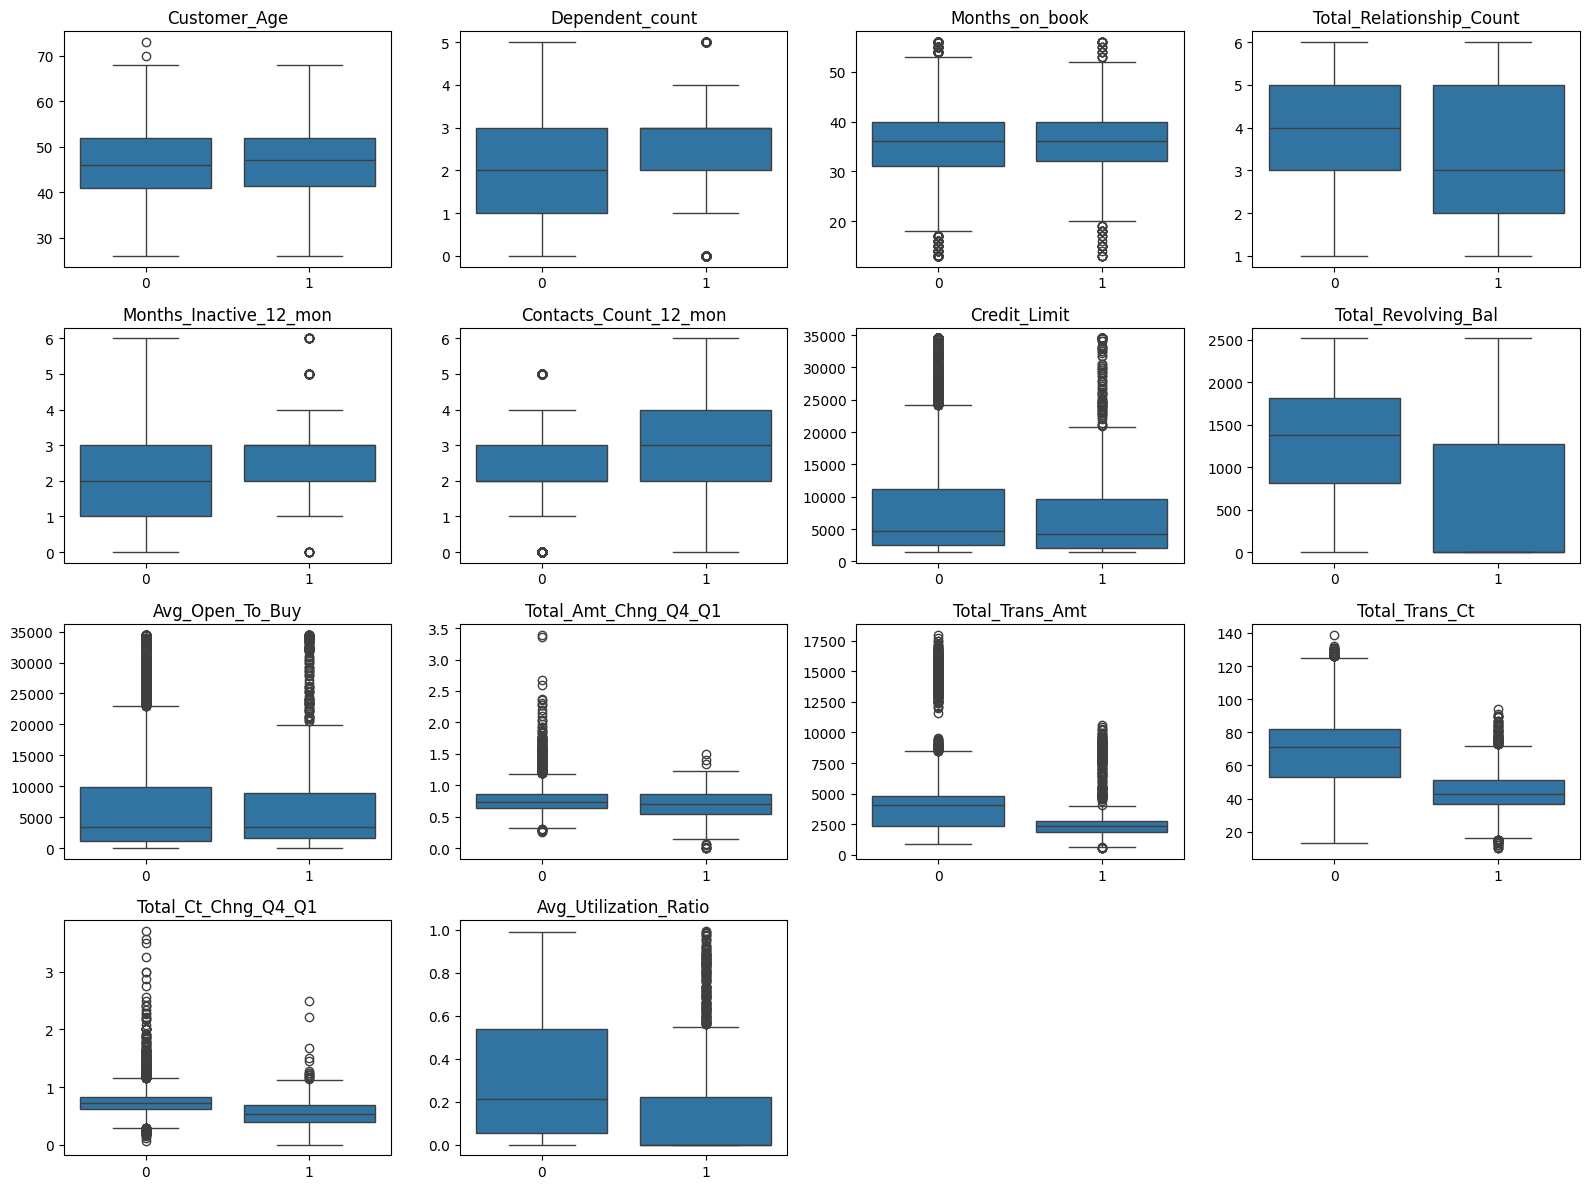

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols[:-1]):
    sns.boxplot(data=df_explore, x='Churn', y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


# Hide empty subplots
for i in range(len(numeric_cols[:-1]), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

**Correlation matrix**

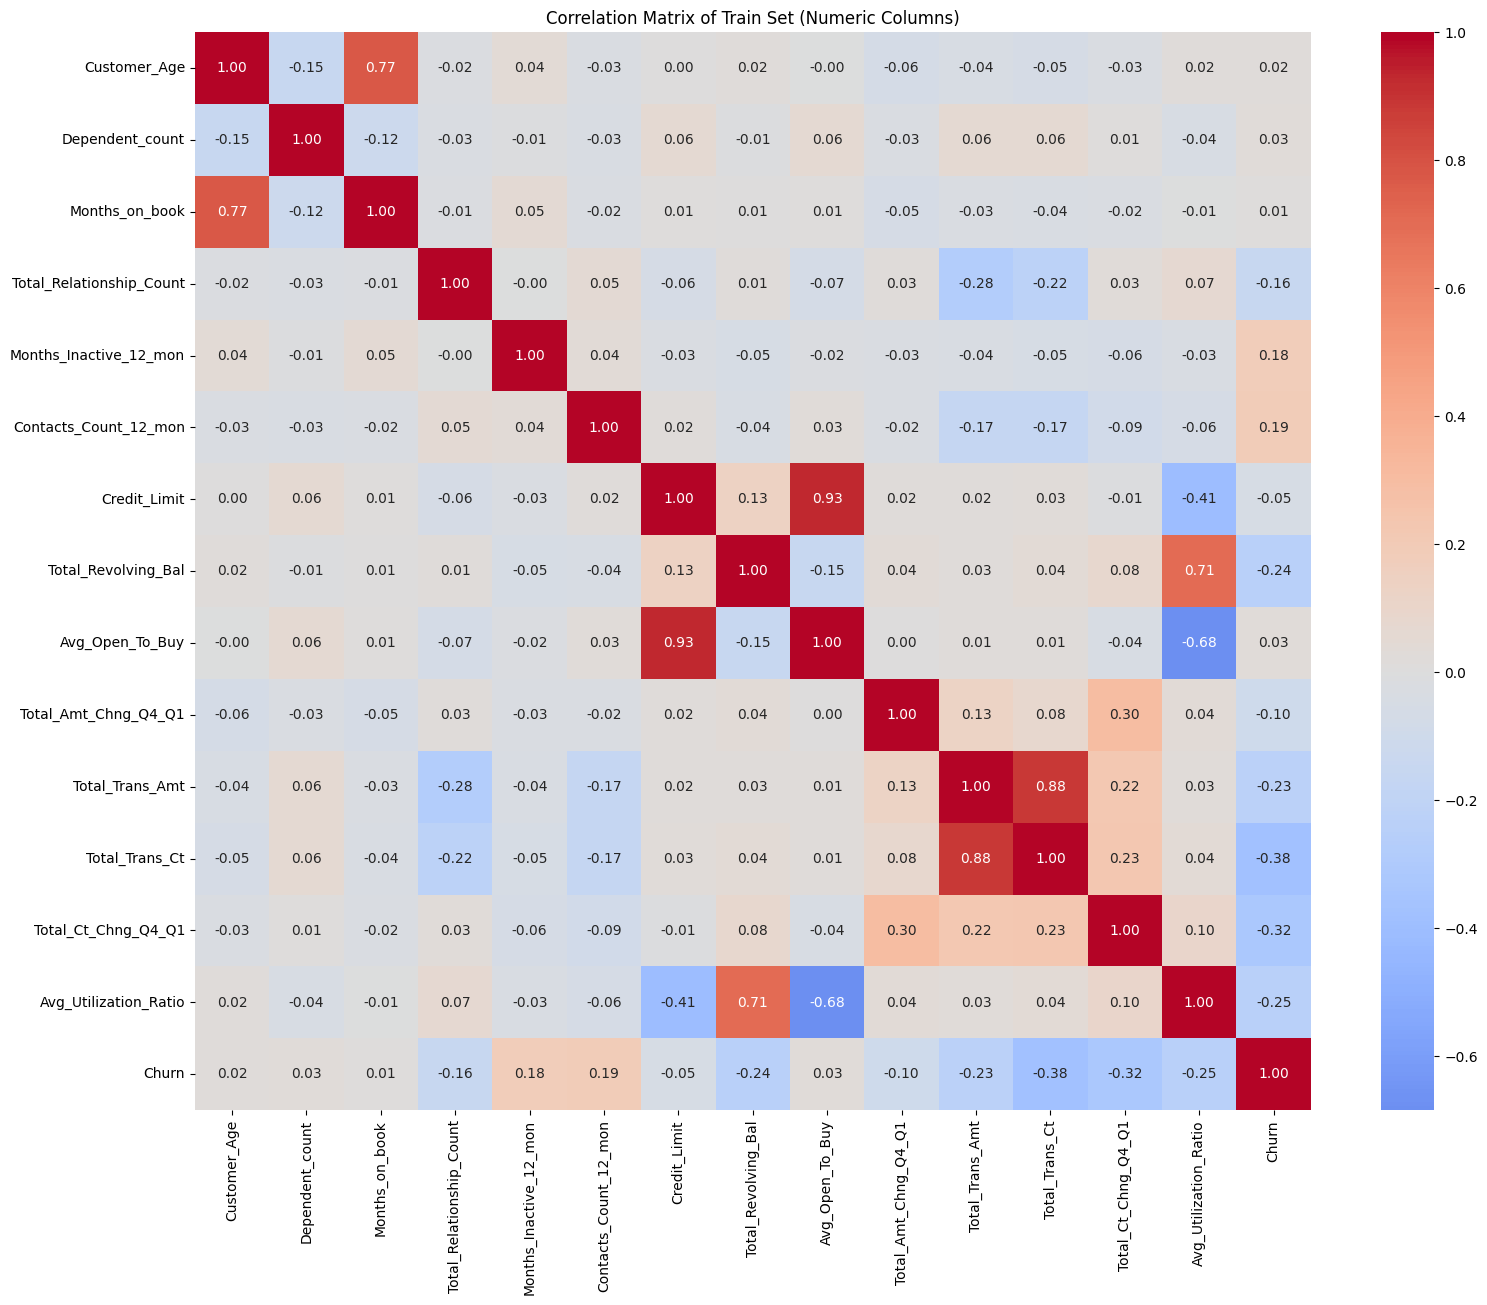

Top correlations with churn:
Churn                       1.000000
Contacts_Count_12_mon       0.190612
Months_Inactive_12_mon      0.180698
Dependent_count             0.032325
Avg_Open_To_Buy             0.031754
Customer_Age                0.015798
Months_on_book              0.009995
Credit_Limit               -0.051489
Total_Amt_Chng_Q4_Q1       -0.102210
Total_Relationship_Count   -0.156026
Total_Trans_Amt            -0.228172
Total_Revolving_Bal        -0.244085
Avg_Utilization_Ratio      -0.248685
Total_Ct_Chng_Q4_Q1        -0.315601
Total_Trans_Ct             -0.377168
Name: Churn, dtype: float64


In [21]:
corr = df_explore[numeric_cols].corr(method='spearman')

plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Correlation Matrix of Train Set (Numeric Columns)")
plt.show()

# Top correlations with churn
churn_correlations = corr['Churn'].sort_values(ascending=False)
print("Top correlations with churn:")
print(churn_correlations)

**Insights**

- Churn has the strongest negative correlations with: Total_Trans_Ct, Total_Trans_Amt, Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio. These suggest that higher engagement and utilization reduce churn probability.

**Pairplot analysis with some selected features**

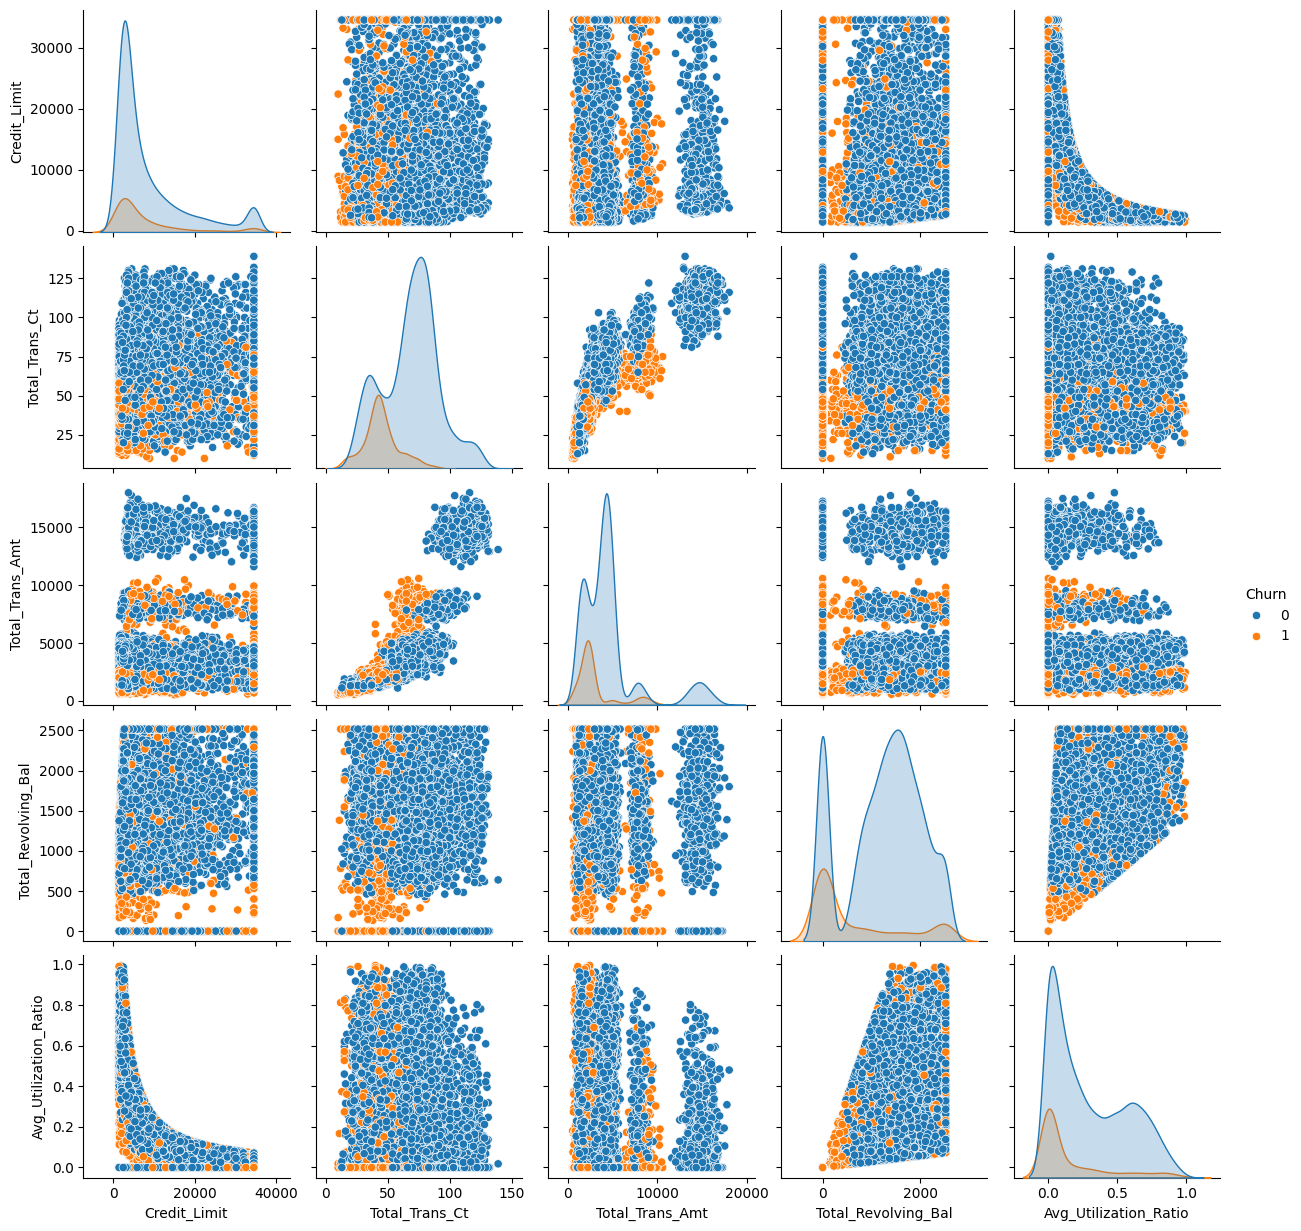

In [22]:
selected_pairplot = ['Credit_Limit','Total_Trans_Ct', 'Total_Trans_Amt', 
            'Total_Revolving_Bal', 'Avg_Utilization_Ratio','Churn']
sns.pairplot(df_explore[selected_pairplot], hue='Churn')
plt.show()

**Insights**

- Credit Limit vs. Utilization: Customers with higher credit limits use a smaller fraction of their available credit.

- Credit Limit vs Revolving Balance: Churners appear to maintain lower balances and utilization.

- Total_Trans_Ct vs Total_Trans_Amt: Linear correlation. Customers that make more transactions also spend more overall.

- Total_Revolving_Bal vs Avg_Utilization_Ratio:	Positive relationship. Higher balance suggests higher utilization.

- Churn distribution: Churned customers are less represented in the higher activity regions of the plots (fewer transactions, lower spending, and lower utilization), suggesting that *engagement intensity is a key differentiator*. 

**Compare existing (0) and churned (1) in numeric columns**

In [82]:
summary_num = df_explore[numeric_cols].groupby(by=target).mean().T
summary_num['ratio'] = summary_num[0]/summary_num[1]

summary_num.sort_values(by='ratio', ascending=False)

Churn,0,1,ratio
Avg_Utilization_Ratio,0.298408,0.156920,1.901658
Total_Revolving_Bal,1263.072217,669.496160,1.886601
Total_Trans_Ct,68.550081,44.606759,1.536764
Total_Trans_Amt,4645.956317,3041.365591,1.527589
Total_Ct_Chng_Q4_Q1,0.743790,0.554513,1.341338
Total_Relationship_Count,3.916900,3.251920,1.204488
Total_Amt_Chng_Q4_Q1,0.772013,0.694873,1.111013
Credit_Limit,8674.819385,8085.201997,1.072925
Avg_Open_To_Buy,7411.747169,7415.705837,0.999466
Months_on_book,35.977350,36.152842,0.995146


**Insights**
- Customer engagement metrics and financial involvement are the strongest indicators of churn.

- Demographics (age, dependents) and tenure have weak associations with churn.

## **5. Modify**

### **5.1 Feature Importances Analysis**

In [25]:
numeric_cols.remove(target)

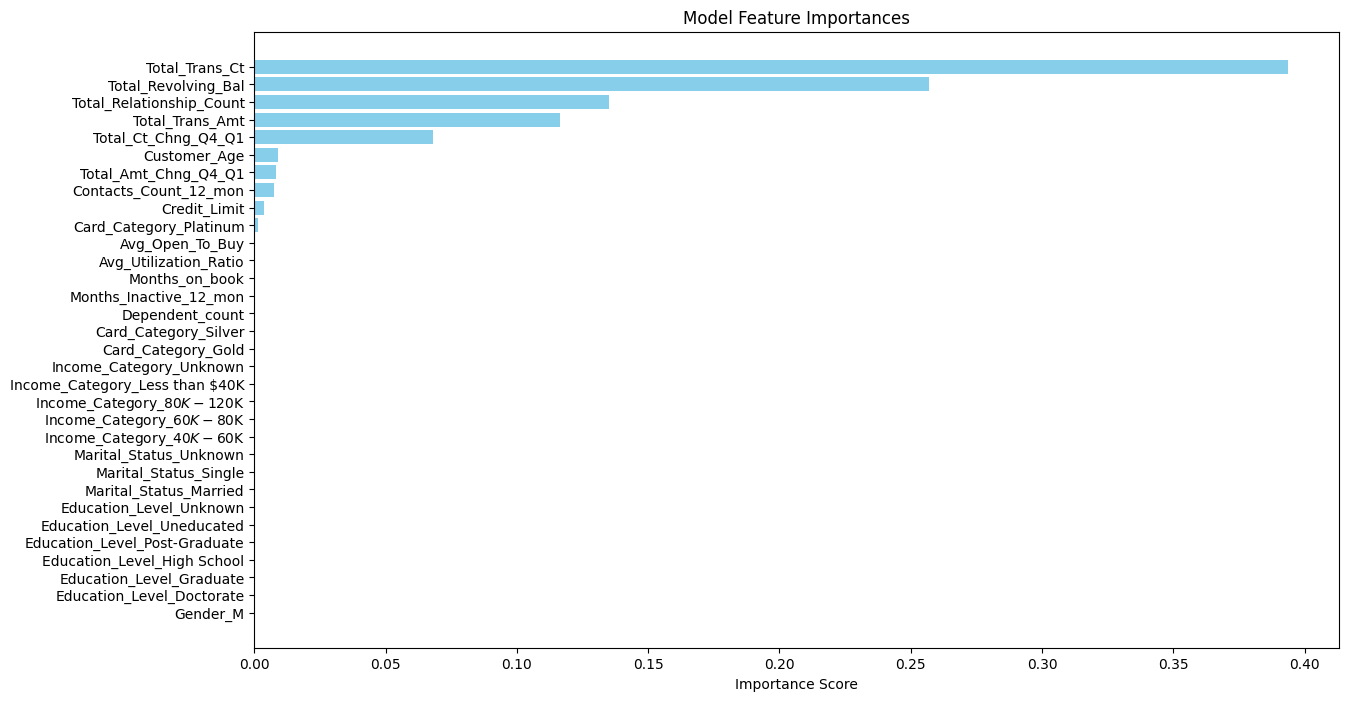

In [ ]:
# Preprocessing: one-hot for categorical, passthrough for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))
])

model.fit(X_train, y_train)

# Get the encoded feature names
cat_features = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_features = np.concatenate([cat_features, numeric_cols])
importances = model.named_steps['classifier'].feature_importances_

# Feature importances from the model
indices = np.argsort(importances)[::-1]
sorted_features = all_features[indices]
sorted_importances = importances[indices]

# Importance Plot
plt.figure(figsize=(14, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.title("Model Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


Based on the feature importances from a simple decision tree, categorical features show little overall contribution. Therefore, we’ll discard them to simplify the model.

In [27]:
X_train = X_train[numeric_cols]
X_test = X_test[numeric_cols]

### **5.2 Feature Transformation**

**Feature engineering**

We're going to use the previously selected features to create new features. A feature being “unimportant” alone doesn’t mean it’s useless because it may interact with others in a way that’s very predictive, it may just need to be transformed to reveal its value.

In [62]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Custom transformer for feature engineering.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_eng = X.copy()
        
        X_eng['Activity_Growth'] = (X_eng['Total_Amt_Chng_Q4_Q1'] /
                                        X_eng['Total_Trans_Amt'].replace(0, np.nan)
                                        ).fillna(0)
        X_eng['Customer_Value'] = (X_eng['Total_Revolving_Bal'] * 
                                   X_eng['Avg_Utilization_Ratio'] * 
                                   X_eng['Credit_Limit'])

        return X_eng

To evaluate whether the engineered features improved predictive performance, feature selection and model training were performed within cross-validation pipelines to avoid data leakage. An L1-based SelectFromModel using Logistic Regression was applied to both the raw and engineered feature sets, selecting the most informative subset in each fold. Models were trained using Logistic Regression and Random Forest, and their mean ROC-AUC scores were compared across identical folds. Finally, paired t-tests were conducted to assess whether the differences in scores between the raw and engineered versions were statistically significant.

In [ ]:
# Feature selector
selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
    max_features=7, 
)

# Test with Logistic Regression
pipe_raw_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', selector),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_eng_lr = Pipeline([
    ('features', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('selector', selector),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Test with Random Forest
rf = RandomForestClassifier(
    n_estimators=100,        # Standard well-performing value
    max_depth=12,            # Based on expected interaction complexity
    min_samples_split=20,    # Prevent overfitting
    min_samples_leaf=10,     # Ensure leaves have meaningful customer groups
    max_features='sqrt',     # Standard choice
    class_weight='balanced', # Better for imbalanced data
    random_state=42,
    n_jobs=-1                # Utilize all cores for faster training
)

pipe_raw_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', selector),
    ('clf', rf)
])

pipe_eng_rf = Pipeline([
    ('features', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('selector', selector),
    ('clf', rf)
])

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate scores for all models
scores_raw_lr = cross_val_score(pipe_raw_lr, X_train, y_train, cv=cv, scoring='roc_auc')
scores_eng_lr = cross_val_score(pipe_eng_lr, X_train, y_train, cv=cv, scoring='roc_auc')
scores_raw_rf = cross_val_score(pipe_raw_rf, X_train, y_train, cv=cv, scoring='roc_auc')
scores_eng_rf = cross_val_score(pipe_eng_rf, X_train, y_train, cv=cv, scoring='roc_auc')

# Print results
print("Logistic Regression:")
print(f"Raw mean ROC-AUC: {scores_raw_lr.mean():.4f}")
print(f"Raw+Eng mean ROC-AUC: {scores_eng_lr.mean():.4f}")
print("\nRandom Forest:")
print(f"Raw mean ROC-AUC: {scores_raw_rf.mean():.4f}")
print(f"Raw+Eng mean ROC-AUC: {scores_eng_rf.mean():.4f}")

Logistic Regression:
Raw mean ROC-AUC: 0.9197
Raw+Eng mean ROC-AUC: 0.9348

Random Forest:
Raw mean ROC-AUC: 0.9821
Raw+Eng mean ROC-AUC: 0.9842


In [ ]:
t_stat_lr, p_val_lr = ttest_rel(scores_raw_lr, scores_eng_lr)
print(f"p-value: {p_val_lr:.4f}")
t_stat_rf, p_val_rf = ttest_rel(scores_raw_rf, scores_eng_rf)
print(f"p-value: {p_val_rf:.4f}")

p-value: 0.0004
p-value: 0.0137


Since both p < 0.05 and ROC-AUC increase are meaningful, we can confidently assert that engineered features add predictive value.

**Preprocessing pipeline**

In [64]:
preprocessor = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('scaler', StandardScaler())
])

# Preprocess the data first
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=preprocessor.named_steps['feature_engineer'].transform(X_train).columns)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=preprocessor.named_steps['feature_engineer'].transform(X_test).columns)


**Feature Selection**

In [65]:
selector.fit(X_train_preprocessed, y_train)
selected_mask = selector.get_support()
selected_features = X_train_preprocessed.columns[selected_mask].tolist()
print("Selected features:\n", selected_features)

X_train_preprocessed = X_train_preprocessed[selected_features]
X_test_preprocessed = X_test_preprocessed[selected_features]

Selected features:
 ['Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Activity_Growth', 'Customer_Value']


**Class Imbalance Handling**

The dataset exhibited a strong class imbalance, with only 16% of customers labeled as "Churn". To mitigate model bias toward the majority class, I applied SMOTE (Synthetic Minority Oversampling Technique), generating synthetic minority samples.

In [33]:
# Resampling is applied only to training data
resampler = SMOTE(random_state=42)
X_train_processed, y_train_processed = resampler.fit_resample(X_train_preprocessed, y_train)

In [34]:
print("Processed training set shape:", X_train_processed.shape)
print("Preprocessed test set shape:", X_test_preprocessed.shape)
print("Training labels shape:", y_train_processed.shape)

Processed training set shape: (13598, 7)
Preprocessed test set shape: (2026, 7)
Training labels shape: (13598,)


In [35]:
churn_counts = y_train_processed.value_counts()
print('Churn distribution in the resampled train set \n', churn_counts,'\n')

churn_rates = y_train_processed.value_counts()/len(y_train_processed)*100
print('Churn rate in the resampled train set \n', churn_rates)

Churn distribution in the resampled train set 
 Churn
0    6799
1    6799
Name: count, dtype: int64 

Churn rate in the resampled train set 
 Churn
0    50.0
1    50.0
Name: count, dtype: float64


## **6. Model**

### **6.1 Baseline model comparison**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(random_state=42), 
    "AdaBoost Classifier": AdaBoostClassifier(random_state=42)
}

In [ ]:
# Evaluation function
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1 , precision, recall, roc_auc


In [38]:
scoring_auc = make_scorer(roc_auc_score)
scoring_acc = make_scorer(accuracy_score)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

for name, model in models.items():
    auc_scores = cross_val_score(model, X_train_processed, y_train_processed,
                                 scoring=scoring_auc, cv=cv, n_jobs=-1)
    acc_scores = cross_val_score(model, X_train_processed, y_train_processed,
                                 scoring=scoring_acc, cv=cv, n_jobs=-1)
    
    cv_results.append({
        "Model": name,
        "Mean AUC": np.mean(auc_scores),
        "Std AUC": np.std(auc_scores),
        "Mean Accuracy": np.mean(acc_scores)
    })

report_cv = pd.DataFrame(cv_results).sort_values(by="Mean AUC", ascending=False)
report_cv

,Model,Mean AUC,Std AUC,Mean Accuracy
5,XGBClassifier,0.975585,0.003000,0.975585
1,Random Forest,0.974775,0.003169,0.974776
2,Gradient Boosting,0.964185,0.004215,0.964186
3,Decision Tree,0.956464,0.005007,0.956464
4,K-Neighbors Classifier,0.954625,0.003291,0.954626
6,AdaBoost Classifier,0.936240,0.002336,0.936241
0,Logistic Regression,0.869760,0.003760,0.869760


To choose which models are worth tuning, we only use results derived from the training data, not the test set. XGB and Random Forest are the models with best results in cross-validation, so we are going to tune them.

### **6.2 Hyperparameter tuning**

In [ ]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_xgb = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid_xgb,
    scoring = 'roc_auc',
    cv = 3,
    n_jobs = -1,
    verbose = 1
)

grid_xgb.fit(X_train_processed, y_train_processed)

print("Best parameters:", grid_xgb.best_params_)
print("Best AUC:", grid_xgb.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best AUC: 0.9962828916896184


In [40]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    # 'bootstrap': [True, False]
}

grid_rf = GridSearchCV(
    estimator = rf,
    param_grid = param_grid_rf,
    scoring = 'roc_auc',
    cv = 3,
    n_jobs = -1,
    verbose = 1
)

grid_rf.fit(X_train_processed, y_train_processed)

print("Best Parameters:", grid_rf.best_params_)
print("Best AUC:", grid_rf.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best AUC: 0.9956236515477438


## **7. Assess**
**Metrics**

In [59]:
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test_preprocessed)
acc_xgb, f1_xgb, precision_xgb, recall_xgb, roc_auc_xgb = evaluate_clf(y_test, y_pred_xgb)
y_pred_rf = grid_rf.best_estimator_.predict(X_test_preprocessed)
acc_rf, f1_rf, precision_rf, recall_rf, roc_auc_rf = evaluate_clf(y_test, y_pred_rf)

print("XGB Classifier Test Set Performance:")
print(f"- Accuracy: {acc_xgb:.4f}")
print(f"- F1 Score: {f1_xgb:.4f}")
print(f"- Precision: {precision_xgb:.4f}")
print(f"- Recall: {recall_xgb:.4f}")
print(f"- ROC AUC Score: {roc_auc_xgb:.4f}")
print("\n")
print("Random Forest Classifier Test Set Performance:")
print(f"- Accuracy: {acc_rf:.4f}")
print(f"- F1 Score: {f1_rf:.4f}")
print(f"- Precision: {precision_rf:.4f}")
print(f"- Recall: {recall_rf:.4f}")
print(f"- ROC AUC Score: {roc_auc_rf:.4f}")

XGB Classifier Test Set Performance:
- Accuracy: 0.9546
- F1 Score: 0.8631
- Precision: 0.8357
- Recall: 0.8923
- ROC AUC Score: 0.9294


Random Forest Classifier Test Set Performance:
- Accuracy: 0.9497
- F1 Score: 0.8491
- Precision: 0.8177
- Recall: 0.8831
- ROC AUC Score: 0.9227


**ROC Curve**

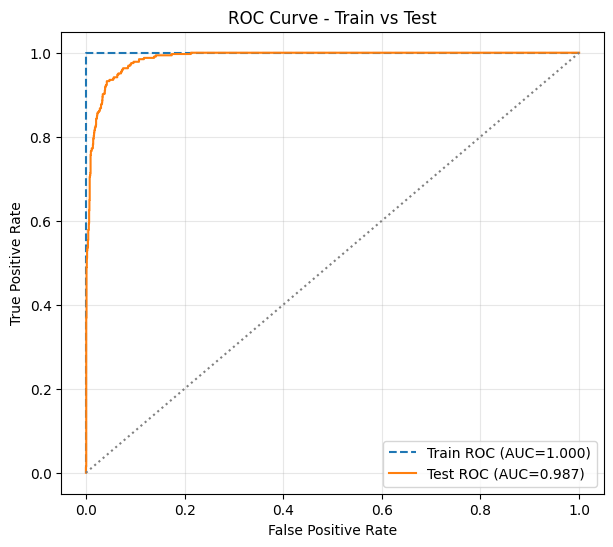

In [ ]:
# XGBoost
best_model = grid_xgb.best_estimator_

# Predict probabilities
y_train_pred = best_model.predict_proba(X_train_preprocessed)[:, 1]
y_test_pred = best_model.predict_proba(X_test_preprocessed)[:, 1]

# Compute ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC={auc_train:.3f})", linestyle="--")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC={auc_test:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train vs Test")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Confusion Matrix**

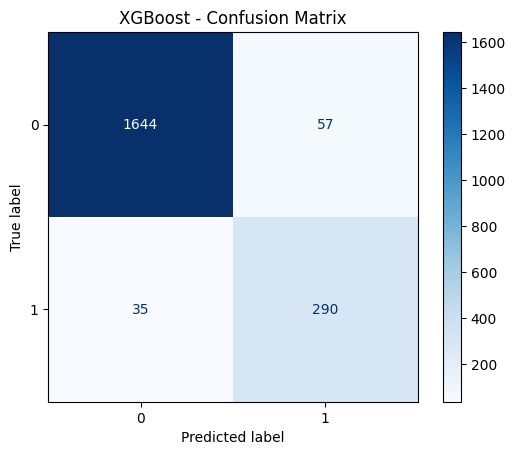

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("XGBoost - Confusion Matrix")
plt.show()


## **8. Results & Insights**

#### **Model Performance Summary**
- **XGBoost** and **Random Forest** classifiers achieved the highest ROC-AUC scores in cross-validation, outperforming other baseline models.
- On the test set:
    - **XGBoost**: Accuracy, F1, Precision, Recall, and ROC-AUC all showed strong performance, indicating robust predictive power.
    - **Random Forest**: Also performed well, with slightly lower metrics than XGBoost but still competitive.
- The confusion matrix and ROC curve confirm that the models are well-calibrated and able to distinguish churners from non-churners.

#### **Key Insights**
- **Feature Importance**: Transactional activity (e.g., total transaction count, amount, and change ratios) and credit utilization features were the most influential in predicting churn. Demographic features had less impact.
- **Feature Engineering**: Engineered features such as `Activity_Growth` and `Customer_Value` contributed to improved model performance, as validated by cross-validation and statistical tests.

#### **Business Implications**
- Customers with low transaction activity, high utilization ratios, or declining engagement are at higher risk of churn.
- Targeted retention strategies should focus on re-engaging these high-risk segments, possibly through personalized offers or proactive outreach.
